# Working with SeismicBatch

## Content
* [Indexing data](#Indexing-data)
* [Actions](#Actions)
    * [Load](#Load)
    * [Visualization](#Visualization)
        * [Seismic_plot](#Seismic-plot)
        * [Wiggle_plot](#Wiggle-plot)
        * [Interactive batch scrolling](#Interactive-batch-scrolling)
        * [Spectrum_plot](#Spectrum-plot)
        * [Statistics_plot](#Statistics-plot)
    * [Sorting](#Sorting)
    * [Signal processing](#Signal-processing)
    * [Field straightening](#Field-straightening)
    * [Spherical divergence correction](#Spherical-divergence-correction)
    * [Export](#Export)
* [Utils](#Utils)
    * [Merging files](#Merging-files)

## Indexing data

Work with seismic data starts with data indexing. See the [tutorial](./index.ipynb) on index to recall different index types.

In [1]:
import os
import sys
import dill
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt 

sys.path.append('..')

from seismicpro.batchflow import V, P, B, R
from seismicpro.src import (SeismicDataset,
                            FieldIndex, TraceIndex, CustomIndex, 
                            merge_segy_files, gain_plot, seismic_plot,
                            calculate_sdc_quality)
from seismicpro.src.utils import make_index

Here we consider ```FieldIndex``` that enumerates field records of two files that we will refer as ```raw``` and ```lift```:

In [2]:
path_raw = '/data/H1_WZ/NA/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/data/H1_WZ/NA/DN02B_SHOTS_LIFT1.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
               .merge(FieldIndex(name='lift', path=path_lift)))

field_index.head()

TraceNumber offset TRACE_SEQUENCE_FILE  \
                                               raw   
FieldRecord                                          
111906             1656     35                   1   
111906             1657     36                   2   
111906             1655     78                   3   
111906             1658     79                   4   
111906             1654    127                   5   

                                           file_id TRACE_SEQUENCE_FILE  \
                                               raw                lift   
FieldRecord                                                              
111906       /data/H1_WZ/NA/DN02A_LIFT_AMPSCAL.sgy                   1   
111906       /data/H1_WZ/NA/DN02A_LIFT_AMPSCAL.sgy                   2   
111906       /data/H1_WZ/NA/DN02A_LIFT_AMPSCAL.sgy                   3   
111906       /data/H1_WZ/NA/DN02A_LIFT_AMPSCAL.sgy                   4   
111906       /data/H1_WZ/NA/DN02A_LIFT_AMPSCAL.sgy                   5   

                                          file_id  
                                             lift  
FieldRecord                                        
111906       /data/H1_WZ/NA/DN02B_SHOTS_LIFT1.sgy  
111906       /data/H1_WZ/NA/DN02B_SHOTS_LIFT1.sgy  
111906       /data/H1_WZ/NA/DN02B_SHOTS_LIFT1.sgy  
111906       /data/H1_WZ/NA/DN02B_SHOTS_LIFT1.sgy  
111906       /data/H1_WZ/NA/DN02B_SHOTS_LIFT1.sgy

## Actions

### Load

Action ```load``` reads sets of traces from SEGY files and stores them in batch components. You can manage which components to load setting ```components``` parameter. Depending on batch index type each set of traces is represended by a signle trace (in case of ```TraceIndex```), or traces that correspond to a single field record (in case of ```FieldIndex```), or all traces from a single bin (in case of ```BinsIndex```) etc.

In each component items traces are loaded in the same order as rows in index DataFrame.

One can load not the whole trace but its specific slice. Use ```tslice``` parameter to specify which slice to load. For illustration, let's load first 3000 samples of each trace in ```raw``` and ```lift``` components:

In [3]:
batch = (SeismicDataset(field_index).next_batch(10)
         .load(fmt='segy', components=('raw', 'lift'), tslice=slice(3000)))

Now batch contains 10 items in components ```raw``` and ```lift```. Traces in batch items have common field record id. Each trace is limited to 3000 samples.

In [4]:
batch.raw.shape, batch.lift.shape, batch.raw[0].shape

((10,), (10,), (3456, 3000))

In contrast, working with ```TraceIndex``` we will load single traces in batch items:

In [5]:
trace_batch = (SeismicDataset(TraceIndex(field_index)).next_batch(10)
              .load(fmt='segy', components=['raw', 'lift'], tslice=slice(3000)))

trace_batch.raw.shape, trace_batch.lift.shape, trace_batch.raw[0].shape

((10,), (10,), (1, 3000))

### Visualization

Below we illustrate various options for batch items visualization.

#### Seismic plot

By default, ``` seismic_plot``` is similar to ```matplotlib.pyplot.imshow``` and shows multiple traces of a single batch item for single or many batch components. Example of single batch component visualization:

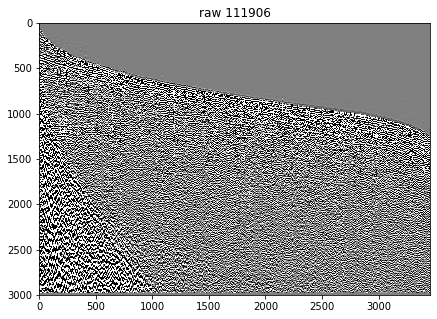

In [6]:
cv = 0.1
batch.seismic_plot('raw', batch.indices[0],
                   figsize=(7, 5), vmin=-cv, vmax=cv, cmap='gray')

Example of several batch component visualization:

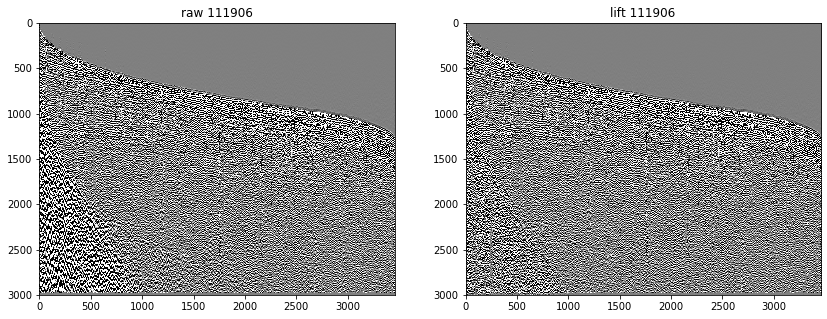

In [7]:
batch.seismic_plot(('raw', 'lift'), batch.indices[0], figsize=(14, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

Show a specific region bounded by ```xlim``` and ```ylim``` parameters:

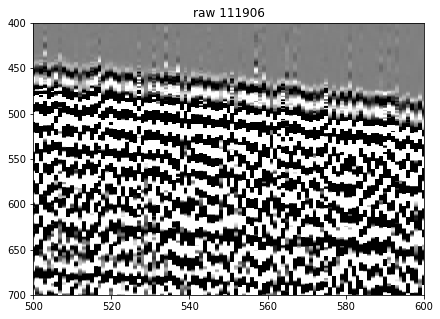

In [8]:
batch.seismic_plot('raw', batch.indices[0], xlim=(500, 600), ylim=(400, 700),
                   figsize=(7, 5), vmin=-cv, vmax=cv, cmap='gray')

Note that if batch component consists of a signle trace it will be plotted with ```matplotlib.pyplot.plot``` function:

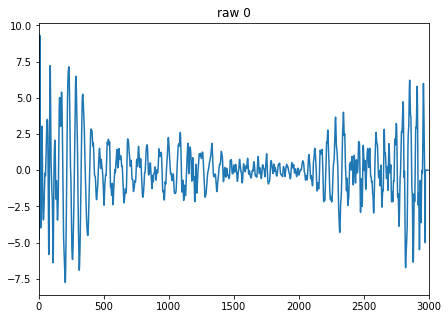

In [9]:
trace_batch.seismic_plot('raw', trace_batch.indices[0], figsize=(7, 5))

#### Wiggle plot

Wiggle plot shows seismic traces as waves. To activete this mode pass ```wiggle=True``` to ```seismic_plot```. For example let\`s show a specific region bounded by ```xlim``` and ```ylim``` parameters in a **wiggle** representation (Hint: use ```std``` parameter to control amptitudes):

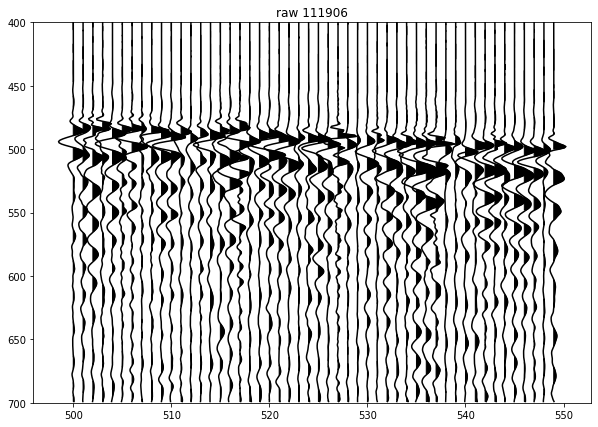

In [10]:
batch.seismic_plot('raw', batch.indices[0], wiggle=True, std=0.15,
                   xlim=(500, 550), ylim=(400, 700), figsize=(10, 7))

Single trace can be also shown in the wiggle form: 

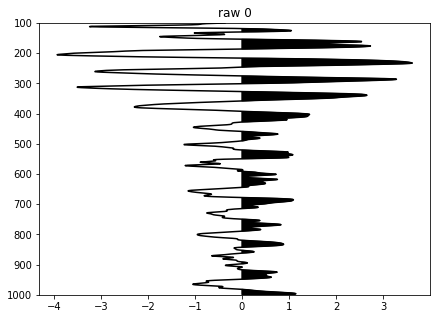

In [11]:
trace_batch.seismic_plot('raw', trace_batch.indices[0], wiggle=True,
                         ylim=(100, 1000), figsize=(7, 5))

#### Interactive batch scrolling

To interactively iterate over batch items use ```items_viewer``` as follows:
```python
fig, tracker = batch.items_viewer('raw', vmin=-cv, vmax=cv, cmap='gray')
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()
```

#### Spectrum plot

```spectrum_plot``` shows traces and averaged signal power within specified region. For example we select traces from 200 to 400 (in offset sorting) and samples from 1700 to 2700 and compare signal power spectrum for batch components ```raw``` and ```lift```:

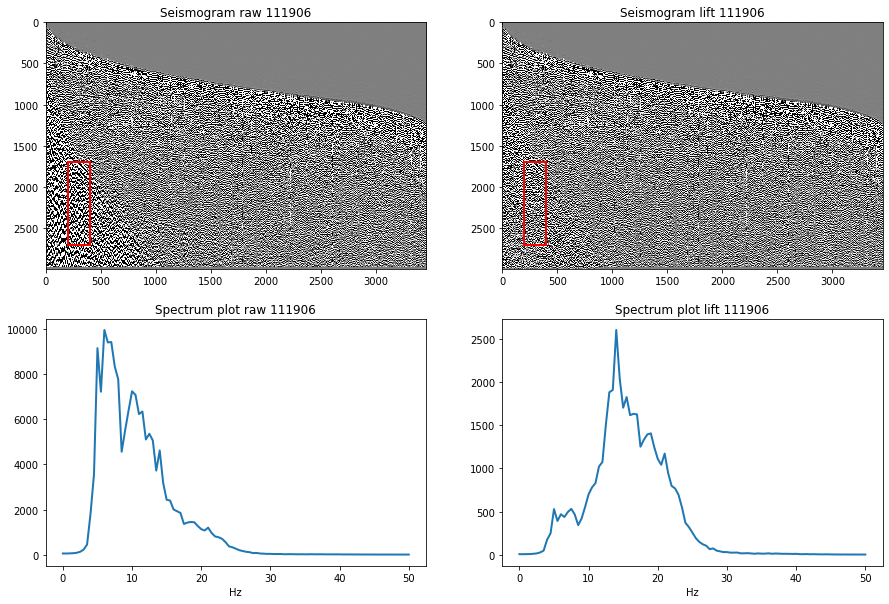

In [12]:
batch.spectrum_plot(('raw', 'lift'), batch.indices[0],
                    frame=(slice(200, 400), slice(1700, 2700)), 
                    max_freq=50, figsize=(15, 10),
                    vmin=-cv, vmax=cv, cmap='gray')

#### Statistics plot

```statistics_plot``` shows trace features such as dominant frequency (rms frequency), mean absolute amplitude, rms amplitude as well as custom defined statistics. E.g. for dominant (rms) frequency:

../seismicpro/src/plot_utils.py:319: RuntimeWarning: invalid value encountered in true_divide
  spec = spec / spec.sum(axis=1).reshape((-1, 1))


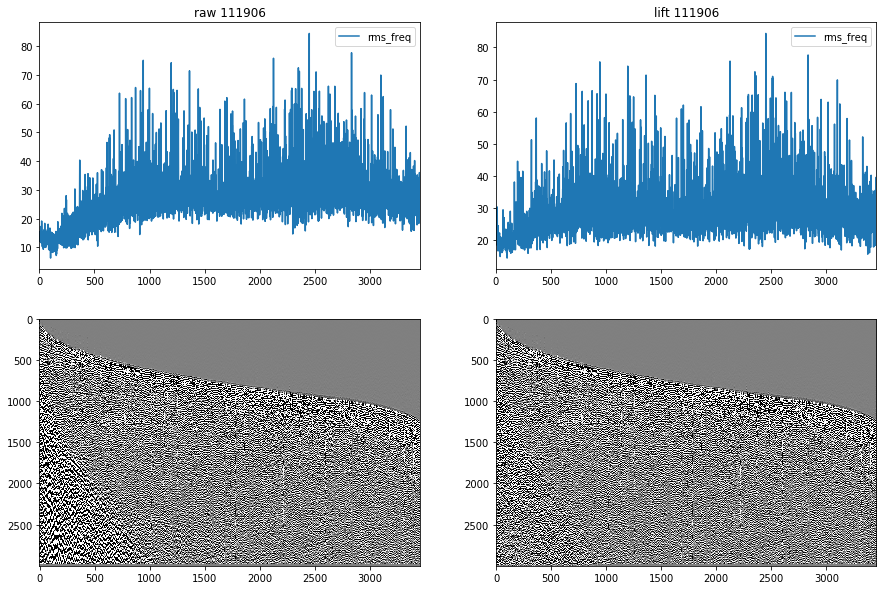

In [13]:
batch.statistics_plot(('raw', 'lift'), batch.indices[0], stats='rms_freq', figsize=(15, 10),
                      vmin=-cv, vmax=cv, cmap='gray')

In the next plot we show both mean absolute amplitude and rms amplitude:

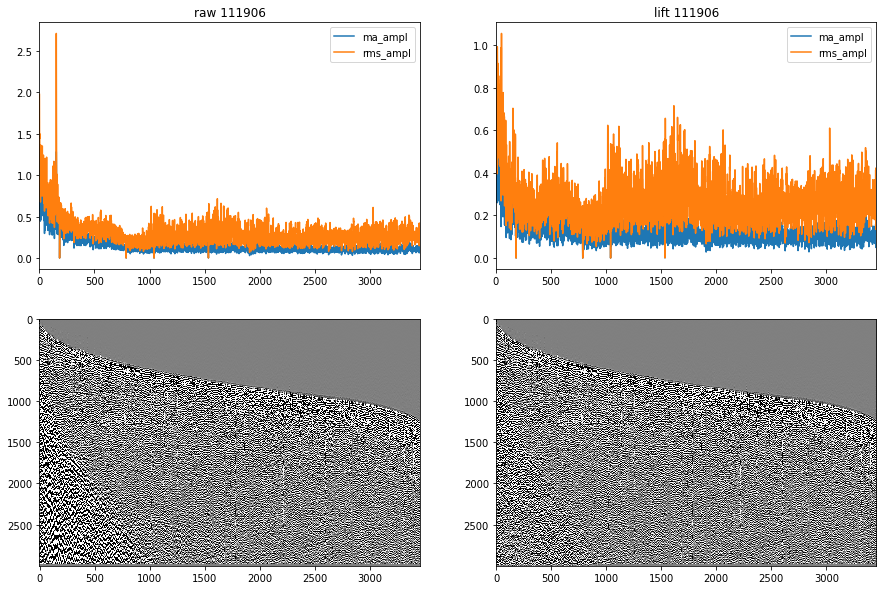

In [14]:
batch.statistics_plot(('raw', 'lift'), batch.indices[0], stats=['ma_ampl', 'rms_ampl'],
                      figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

One can also plot custom defined statistics. E.g. consider median absolute amplitude in comparison to mean absolute amplitude:

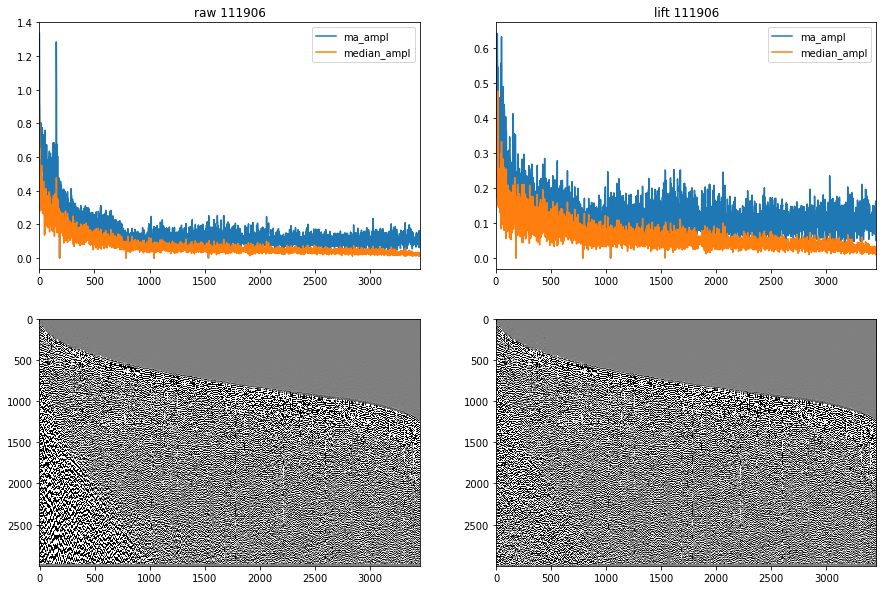

In [15]:
def median_ampl(x, *args):
    return np.median(abs(x), axis=1)

batch.statistics_plot(('raw', 'lift'), batch.indices[0], stats=['ma_ampl', median_ampl],
                      figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

### Sorting

Trace sorting order can be checked in components meta. By default, loaded traces have no specified order:

In [16]:
print(batch.meta['raw']['sorting'])

None


Trace sorting order can be changed by ```sort_traces``` action (note this action does not affect rows order in the index DataFrame):

In [17]:
batch.sort_traces(src='raw', dst='raw_sorted', sort_by='TraceNumber')

Check new sorting order:

In [18]:
batch.meta['raw_sorted']['sorting']

'TraceNumber'

Show traces in new sorting:

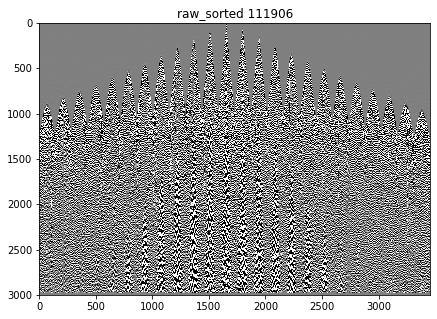

In [19]:
batch.seismic_plot('raw_sorted', 111906, figsize=(7, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

### Signal processing

There is a number of built-in signal processing methods that can be applied to traces, e.g. Fourier transform, gradient or various wavelet transforms. E.g. consider gradient and Fourier transform:

In [20]:
batch.gradient(src='raw', dst='grad_raw')
batch.rfft(src='raw', dst='fft_raw')

Besides built-in methods, any custom fuction can be applied either to axix of batch item (```apply_along_axis```) or to the whole batch item (```apply_transform```). For exmaple, consider median filtration ```scipy.signal.medfilt```:

In [21]:
batch.apply_transform(medfilt, kernel_size=(9, 1), src='raw', dst='medfilt')

Show the filtered seismogram:

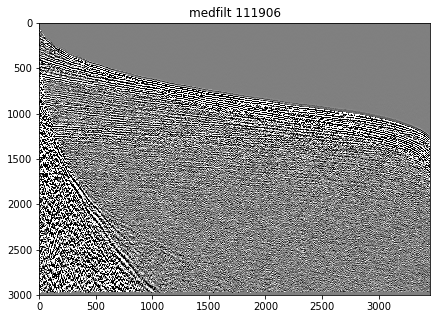

In [22]:
batch.seismic_plot('medfilt', 111906, figsize=(7, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

### Cropping

Action `crop` extracts crops from traces or seismic gathers in `src` component and puts an array with crops to `dst` component. Crops are specified by `coords` of upper left corner and `shape`.

Action `assemble` combines crops from `src` component into a new array of traces. The resulting array has the shape of source of crops and the area that is not covered with crops is filled with zeros. If some crops overlap, their mean is taken.

In [23]:
SHAPE=(50, 500)
N_RANDOM_CROPS = 5

batch = (SeismicDataset(field_index).p
        .load(components='raw', fmt='segy')
        .sort_traces(src='raw', dst='raw', sort_by='offset')
        .crop(src='raw', dst='crops', coords=P(R('uniform', size=(N_RANDOM_CROPS, 2))), shape=SHAPE)
        .assemble_crops(src='crops', dst='assemble')
        ).next_batch(2)

The source of crops and coordinates of their upper left corners in the original array are stored in the componet's meta.

In [24]:
batch.meta['crops']

{'crop_coords': {111906: array([[1959,  985],
         [ 623, 2372],
         [  40, 1227],
         [ 763, 1850],
         [ 414,  708]]), 111907: array([[ 900, 2339],
         [2468, 1987],
         [1342,  101],
         [  89, 2391],
         [3305,  936]])}, 'source': 'raw'}

`crop_plots` shows crops that are stored in given component. Parameters are pretty much the same as those of `seismic_plot`.

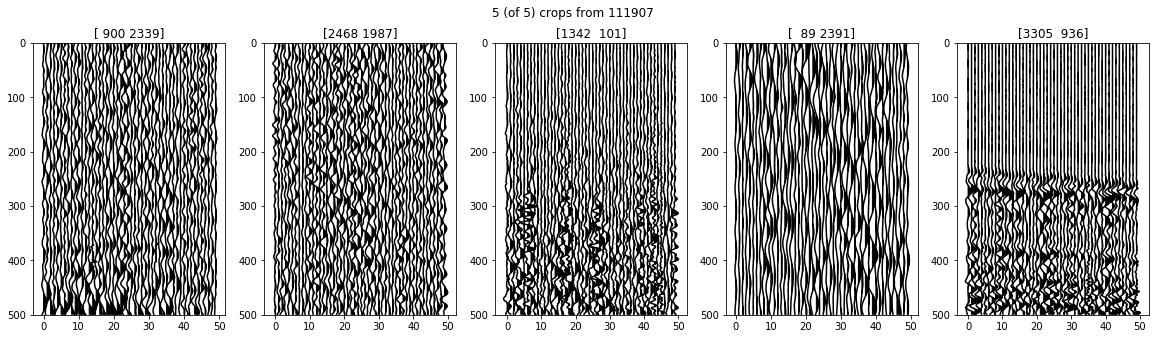

In [25]:
batch.crops_plot('crops', batch.indices[-1], wiggle=True, std=0.3, figsize=(20, 5))

The plot below shows the original array and the one assembled of random crops. Note that some of the crops might not be visible because they are taken from areas with very low amplitudes.

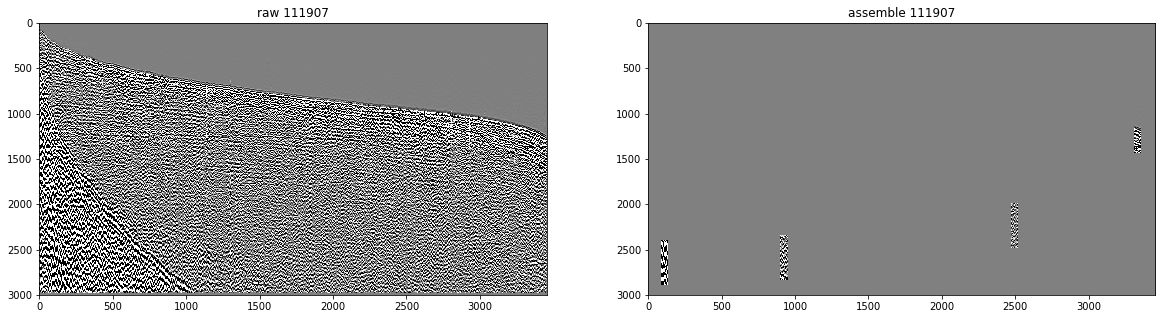

In [26]:
batch.seismic_plot(['raw', 'assemble'], batch.indices[-1], cmap='gray', vmin=-0.1, vmax=0.1, figsize=(20, 5))


To generate crops that cover the whole array one can use `make_grid_for_crops`. It generates coordinates of crops with given shape for each array in a batch, so that these crops cover the whole array. 

If `drop_last` is `False` then the last crops along each axis are kept even if they don't fit into the original array. Then those coordinates are passed to `crop` `pad_zeros` should be set to `True`, so that crops that don't fit into the original array are padded with zeros. Othewize an exception will be raised. 

`assemble_crops` restores the original size of crops source.

In [27]:
SHAPE=(1000, 1000)

batch = (SeismicDataset(field_index).p
        .load(components='raw', fmt='segy')
        .sort_traces(src='raw', dst='raw', sort_by='offset')
        .make_grid_for_crops(src='raw', dst='coords', shape=SHAPE, drop_last=False)
        .crop(src='raw', dst='crops', coords=P(B('coords')), shape=SHAPE, pad_zeros=True)
        .assemble_crops(src='crops', dst='assemble')
        ).next_batch(1)

When `num_crops` is passed to `crops_plot`, only that number of random crops is shown.

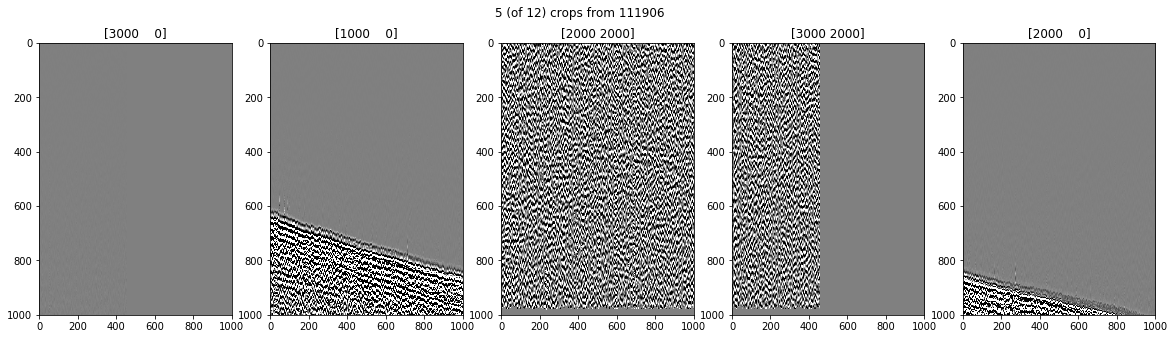

In [28]:
batch.crops_plot('crops', batch.indices[-1], num_crops=5, cmap='gray', vmin=-0.1, vmax=0.1, figsize=(20, 5))

The original seismic gather and the one assembled from crops are exactly same.

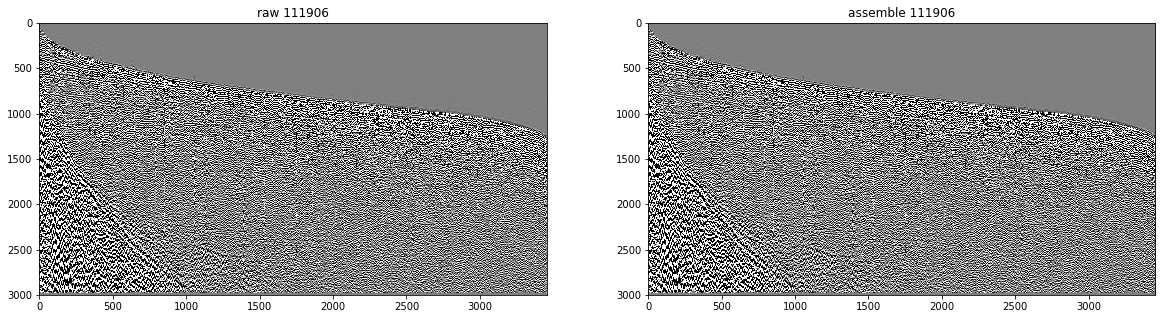

In [29]:
batch.seismic_plot(['raw', 'assemble'], batch.indices[-1], cmap='gray', vmin=-0.1, vmax=0.1, figsize=(20, 5))

### Field straightening
Field with CDP sorting needs to be straightened out before analysis in propuse to reduce normal addition. This process describes by the following equation:
$$\vartriangle t = \sqrt{t_0^2 + \frac{l^2}{V^2}} $$
* $t_0$ - time value with zero offset.
* $V$ - speed in moment $t$.
* $l$ - offset.


Thus new amplitude value in the moment ```t``` and with offset ```x``` calculated as:
$$A(t,\ x) = A(t \ + \vartriangle t, \ x)$$

Create ```CustomIndex``` with ```CDP``` as index column.
Velocities were calculated by a specialist specifically for the field.

In [30]:
paths = {
    'raw': '/data/H1_WZ/NA/raw_cdp_60.sgy',
    'lift': '/data/H1_WZ/NA/lift_cdp_60.sgy',
}
components = list(paths.keys())

bindex = make_index(paths, index_type=CustomIndex, extra_headers=['offset'], index_name='CDP')

# time(ms): velocity (m/s)
velocities = {
    34: 1601,
    292: 1721,
    466: 1774,
    1080: 1994,
    1432: 2195,
    1658: 2376,
    2026: 2648,
    2262: 2726,
    2484: 2836,
    3078: 3076,
    3390: 3195,
    3670: 3295,
    5952: 4057
}

Load CDP seismograms and straighten them using pre-defined velocities. Velocities for missing time valuse are interpolated

In [31]:
batch = (SeismicDataset(bindex).p
         .load(components=components, fmt='segy', tslice=np.arange(3000))
         .sort_traces(src='raw', dst='raw', sort_by='offset')
         .sort_traces(src='lift', dst='lift', sort_by='offset')
         .hodograph_straightening(velocities=sorted(list(velocities.items())), src=['raw', 'lift'], dst=['raw_s', 'lift_s'])
         ).next_batch(1)

Let's draw two components and compare the difference.

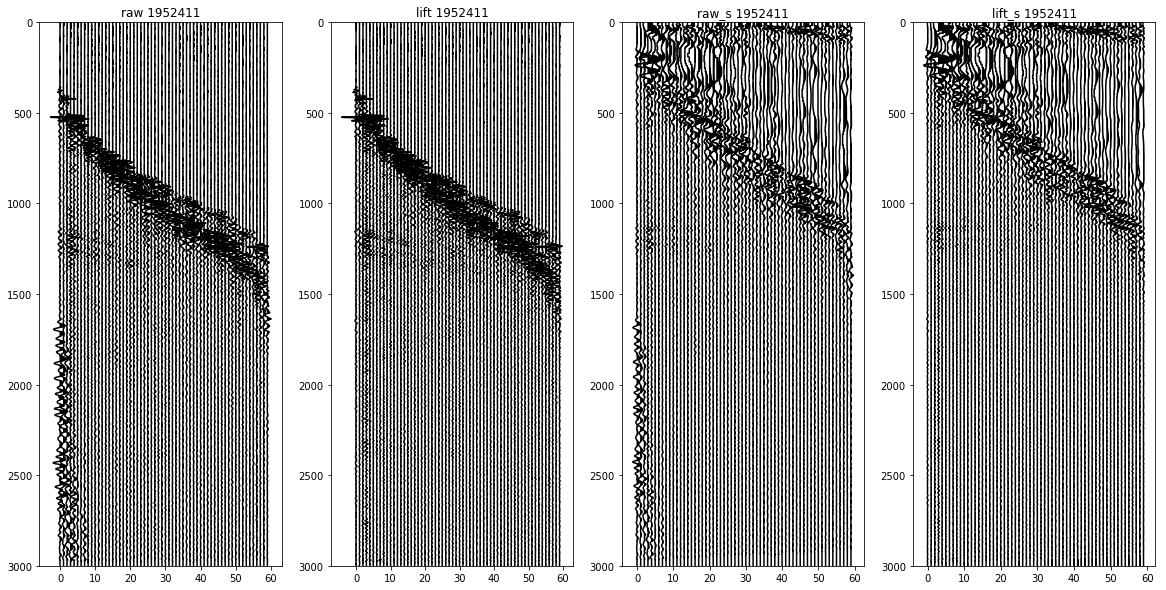

In [32]:
batch.seismic_plot(batch.components, batch.indices[0],
                   figsize=(20, 10), wiggle=True, std=0.2);

Level lines are straightened on the right graph.

### Spherical divergence correction
Amplitude attenuation with time called _spherical divergence_. To compensate this process we introduce correction function $g(t)$:
$$ g(t) = \frac{V_{rms}^{v_{pow}}(t) * t^{t_{pow}}}{V_0} \ where, $$
* $V_{rms}(t)$ - root mean square speed.
* t - time.
* $V_0$ - speed at time 0.

$V_{pow}$ and $t_{pow}$ are parameters that need to be estimated.

Corrected amplitude calculated as:
$$A_{new}(t) = A(t) * g(t)$$

We'll use predefined value for $V(t)$. Speed is measured in milliseconds. Time can be measured either in milliseconds or in samples.

In [33]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)
sph_index = FieldIndex(name='raw', extra_headers=['offset'],
                       path='/data/SD/dataset_1/2_TAR_raw.sgy')

There are two options to correct sperical divergence:
* Run spherical divergence correction with user-provided values for parameters.
* Run correction using parameters automatically estimated in an optimization procedure.

In this notebook each of them will be described separately.

#### Manual tuning
For manual correction use ```correct_spherical_divergence``` action and pass parameter values to ```params``` argument of the action:

In [34]:
batch = (SeismicDataset(sph_index).next_batch(1)
         .load(fmt='segy', components='raw', tslice=slice(3000))
         .sort_traces(src='raw', dst='raw', sort_by='offset')
         .correct_spherical_divergence(src='raw', dst='corrected',
                                       speed=speed, params=(2, 1))
)

It will be useful to look at the difference between the original seismogram and the corrected one.

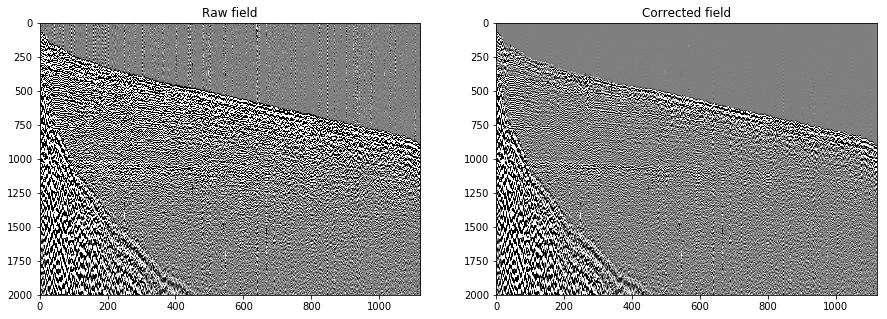

In [35]:
seismic_plot([batch.raw[0], batch.corrected[0]], vmin=-cv, vmax=cv,
             cmap='gray', figsize=(15, 5), names=['Raw field', 'Corrected field'])

More clear this difference shown on gain plot.

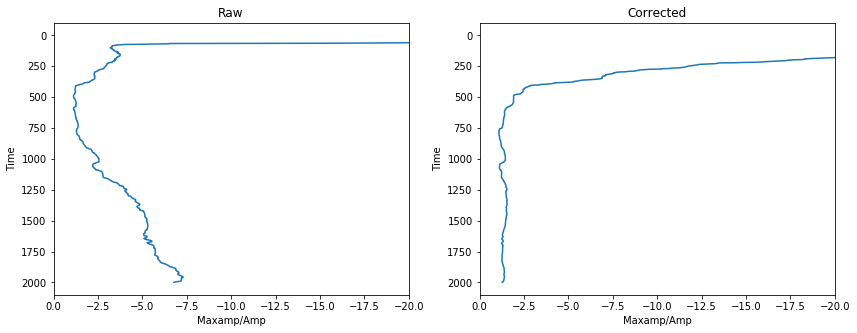

In [36]:
gain_plot([batch.raw[0], batch.corrected[0]], 51, names=['Raw', 'Corrected'],
          figsize=(14, 5), xlim=(0, -20))

It's clear that the difference has narrowed since the correction was made.

#### Automated estimation
To fund the parameters for the whole dataset, you have to use ```SeismicDataset```. Found parameters are unique for each dataset, therefore the optimization method were applied as method of the dataset. You can learn more about this in the [tutorial](./3.Dataset.ipynb) about the dataset. To save found parameters use ```save_to``` argument. Use ```D('attr_name')``` as a parameter to save result into dataset's attribute or ```V('var_name')``` to save result as a pipeline variable.

In [37]:
dataset = SeismicDataset(field_index)

Let's define pipeline that states that we are going to load data and apply spherical convergnce correction. Nothing happens yet, as we state that we want to run pipeline later.

In [38]:
pipeline = (dataset.pipeline()
            .load(fmt='segy', components='raw', tslice=slice(3000))
            .sort_traces(src='raw', dst='raw', sort_by='offset')
            .correct_spherical_divergence(src='raw', dst='corrected',
                                          speed=speed, params=V('sdc_params'))
            .run_later(1, n_iters=1)
)

Optmial parameters will be found before the main pipeline. This part of pipeline named ```pipeline.before```.

In [39]:
(pipeline.before
          .find_sdc_params(component='raw', speed=speed, 
                           loss=calculate_sdc_quality, initial_point=(2, 1),
                           save_to=V('sdc_params'))
);

Now let's run a pipeline.

In [40]:
pipeline.run()

Sesimograms before and after correction.

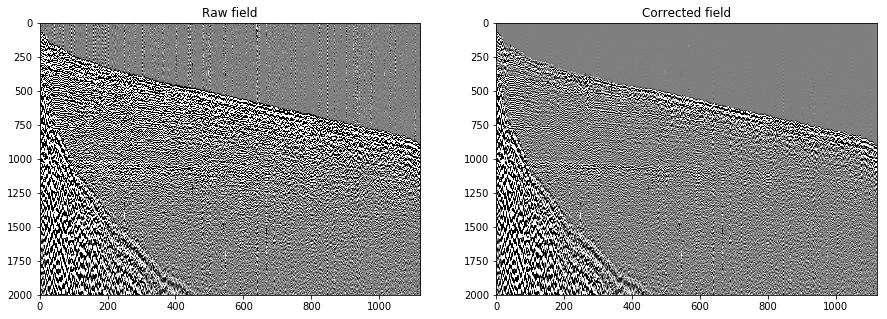

In [41]:
seismic_plot([batch.raw[0], batch.corrected[0]], vmin=-cv, vmax=cv,
              cmap='gray', figsize=(15, 5), names=['Raw field', 'Corrected field'])

Graph of the amplitude difference between raw and corrected data with optimal parameters.

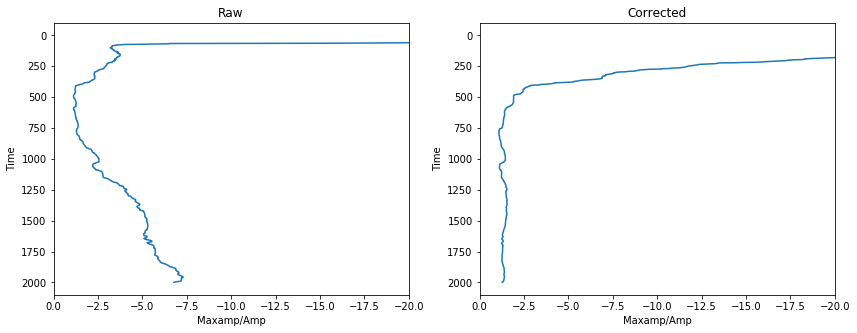

In [42]:
gain_plot([batch.raw[0], batch.corrected[0]], 51, names=['Raw', 'Corrected'],
          figsize=(14, 5), xlim=(0, -20))

One can see, that correction was successful.

### Export

Data in batch components can be dumped in a number of formats:
 * SEGY file
 * first-break picking text file. 

There are two options for export in SEGY files: dump each component item in a separate file (parameter ```split=True```) or dump all traces in a single file (parameter ```split=False```). The next example demonstrates how to export field record in separate files:

In [43]:
dump_path = '/data/NA/dumps/'

batch.dump(fmt='segy', path=dump_path, src='raw', split=True);

## Utils

### Merging files

```merge_segy_files``` and ```merge_picking_files``` allow merging of a set of files into one file. For examples, let's merge all SEGY files from the ```dump_path``` exploited above:

In [44]:
merge_segy_files(path=os.path.join(dump_path, '*sgy'),
                 output_path='/data/NA/merged.sgy')

As an output we obtain a SEGY file ```merged.sgy``` that contains all traces from SEGY files in```dump_path``` directory.

Enjoy!